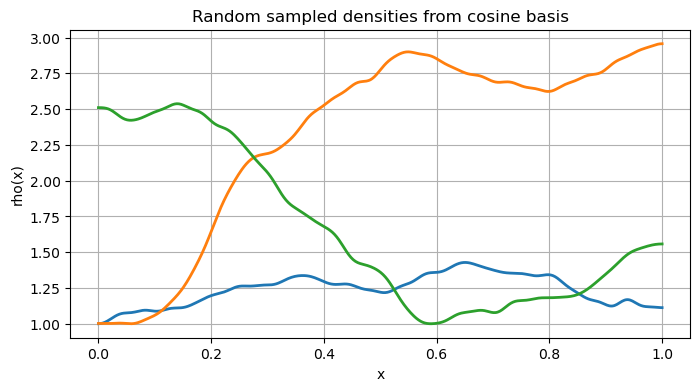

tensor([1427.9187, 4149.7495, 2412.8540, 2163.3779, 2777.4395, 2422.1831,
        1764.9786, 3231.8044, 3006.4463, 3247.8567, 2223.6184, 2523.5247,
        2406.1594, 1422.7747, 1805.6512, 2949.9316, 1302.5083, 1759.9814,
        1826.1228, 1401.8323, 2876.0544, 2089.2490, 1825.8273, 1794.5533,
        2515.2300, 1918.1704, 2195.0991, 1290.6202, 2023.6412, 2114.1179,
        1783.3486, 4124.0771])

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float32
device = "cpu"

M_cutoff = 50 # maximum harmonic
N_grid   = 512
m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
#design matrix needed to sample densities
DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
std_harm = 2.0 / (1.0 + m)**2

def sample_density(*, rho_b=1.0):
    """
    Sample rho_j = rho_avg + sum_{m=1}^M a_m cos(m pi x_j), with x_j in [0,1]
    this sampling of amplitudes a_m implies that the derivatives at the boundaries are zero
    Sampling is done such that the generated density is non-negative everywhere

    Returns:
      rho : (N,) density profile
    """
    
    a = torch.normal(torch.zeros_like(std_harm), std_harm)
    rho = a @ DesignMatrix                            

    rho = rho - rho.min() + rho_b                           # make non-negative
    return rho

def sample_density_batch(B: int, rho_b=1.0):
    """
    Sample a batch of B density profiles.
    Returns rho: (B, N_grid)
    """
    a = torch.normal(torch.zeros(B, std_harm.numel()), std_harm.expand(B, -1))
    rho = a @ DesignMatrix    # (B, N_grid)

    rho_min = rho.min(dim=1, keepdim=True).values
    rho = rho - rho_min + rho_b
    return rho


def E_tot(rho: torch.Tensor) -> torch.Tensor:
    """
    Compute E_tot -- custom functional
    rho: (N,) or (B, N)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    return (rho + rho**2).sum(dim=-1)



# generate one sample
rho_batch = sample_density_batch(32)  # (B, N_grid)

# plot
plt.figure(figsize=(8,4))
plt.plot(x.numpy(), rho_batch[0, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[1, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[2, :].numpy(), lw=2)
plt.xlabel("x")
plt.ylabel("rho(x)")
plt.title("Random sampled densities from cosine basis")
plt.grid(True)
plt.show()


E_tot(rho_batch)  # (B,)
